In [17]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import random

# DCEM with MLP

In [40]:
def deep_cross_entropy(env, num_episodes=1000, elite_frac=0.8, num_samples=200, 
                       max_iter=5000, depth=128, lr=0.01, device="cpu", dtype=torch.float32, goal=200):
    network = nn.Sequential(
        nn.Linear(env.observation_space.shape[0], depth),
        nn.ReLU(),
        nn.Linear(depth, depth),
        nn.ReLU(),
        nn.Linear(depth, env.action_space.n)
    ).to(device)
    softmax = nn.Softmax(dim=1)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=lr)

    def get_action(state, network):
        state = torch.FloatTensor(state).to(device)
        logits = network(state.unsqueeze(0))
        action_prob = softmax(logits).detach().cpu().numpy()[0]
        action = np.random.choice(len(action_prob), p=action_prob)
        return action

    def update_policy(network, elite_sessions):
        elite_states, elite_actions = [], []
        for session in elite_sessions:
            elite_states.extend(session['states'])
            elite_actions.extend(session['actions'])

        elite_states = torch.FloatTensor(elite_states).to(device)
        elite_actions = torch.LongTensor(elite_actions).to(device)

        optimizer.zero_grad()
        loss = loss_fn(network(elite_states), elite_actions)
        loss.backward()
        optimizer.step()

    def get_session(env, network, session_len=max_iter):
        states, actions = [], []
        total_reward = 0
        state = env.reset()

        for _ in range(session_len):
            states.append(state)
            action = get_action(state, network)
            actions.append(action)

            state, reward, done, _ = env.step(action)
            total_reward += reward

            if done:
                break

        return {'states': states, 'actions': actions, 'total_reward': total_reward}

    def get_elite_sessions(sessions, q_param):
        total_rewards = np.array([session['total_reward'] for session in sessions])
        quantile = np.quantile(total_rewards, q_param)

        return [session for session in sessions if session['total_reward'] >= quantile]

    mean_rewards = []

    for epoch in range(num_episodes):
        sessions = [get_session(env, network) for _ in range(num_samples)]
        elite_sessions = get_elite_sessions(sessions, elite_frac)
        if len(elite_sessions) < 1:
            print(f"Epoch {epoch} skipped")
            continue
        update_policy(network, elite_sessions)

        mean_reward = np.mean([session['total_reward'] for session in elite_sessions])
        mean_rewards.append(mean_reward)
        print(f"Epoch {epoch}, Mean Reward: {mean_reward}")
        if len(mean_rewards)>100 and np.mean(mean_rewards[-100:]) >= goal:
            print("Converged!")
            break

    return mean_rewards + [mean_rewards[-1]] * (num_episodes - len(mean_rewards))

# DQN

In [41]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
class QFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [55]:
class DQN:
    def __init__(self, state_dim, action_dim, gamma=0.98, eps_start=1.0, eps_min=0.01, eps_decay_factor=0.98, lr=0.0001, batch_size=1024, memory_size=100000):
        self.q_function = QFunction(state_dim, 128, action_dim).to(DEVICE)
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.epsilon = eps_start
        self.epsilon_decay = eps_decay_factor
        self.epsilon_min = eps_min
        self.memory_size = memory_size
        self.memory_counter = 0
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

        # Preallocate memory
        self.states_memory = torch.empty((memory_size, state_dim), dtype=torch.float32, device=DEVICE)
        self.actions_memory = torch.empty((memory_size, 1), dtype=torch.int64, device=DEVICE)
        self.rewards_memory = torch.empty((memory_size, 1), dtype=torch.float32, device=DEVICE)
        self.dones_memory = torch.empty((memory_size, 1), dtype=torch.float32, device=DEVICE)
        self.next_states_memory = torch.empty((memory_size, state_dim), dtype=torch.float32, device=DEVICE)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            with torch.no_grad():
                action = np.argmax(self.q_function(torch.FloatTensor(state).to(DEVICE)).cpu().numpy()).item()
        return action

    def fit(self, state, action, reward, done, next_state):
        # Store experience in preallocated memory
        index = self.memory_counter % self.memory_size
        self.states_memory[index] = torch.from_numpy(state).to(DEVICE)
        self.actions_memory[index] = torch.tensor([action], device=DEVICE)
        self.rewards_memory[index] = torch.tensor([reward], device=DEVICE)
        self.dones_memory[index] = torch.tensor([done], device=DEVICE)
        self.next_states_memory[index] = torch.from_numpy(next_state).to(DEVICE)
        self.memory_counter += 1

        # Proceed only if we have enough samples in the memory
        if self.memory_counter < self.batch_size:
            return

        # Randomly sample indices for batch
        indices = torch.randint(0, min(self.memory_counter, self.memory_size), (self.batch_size,), device=DEVICE)

        # Use preallocated memory for batch operations
        states = self.states_memory[indices]
        actions = self.actions_memory[indices]
        rewards = self.rewards_memory[indices]
        dones = self.dones_memory[indices]
        next_states = self.next_states_memory[indices]

        # Compute current Q values
        current_q_values = self.q_function(states).gather(1, actions)

        # Compute target Q values
        with torch.no_grad():
            max_next_q_values = self.q_function(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))

        # Compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [56]:
def dqn(env, num_episodes, goal=200):
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    agent = DQN(state_dim, action_dim)
    
    t_max = 5000
    total_rewards = []
    for episode in range(num_episodes):
        total_reward = 0
    
        state = env.reset()
        for t in range(t_max):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            agent.fit(state, action, reward, done, next_state)
    
            state = next_state
    
            if done:
                break
    
        total_rewards.append(total_reward)
        if len(total_rewards) >= 100 and np.mean(total_rewards[-100:]) >= goal:
            print("Converged!")
            break
        print(f'episode: {episode}, total_reward: {total_reward}')
    return total_rewards + [total_rewards[-1]] * (num_episodes - len(total_rewards))

# Setup

In [57]:
env = gym.make('LunarLander-v2')
num_episodes = 100000

# Training

In [ ]:
dqn_rewards = dqn(env, num_episodes=num_episodes)

In [ ]:
deep_cross_entropy_rewards = deep_cross_entropy(env, num_episodes=num_episodes, goal=200)

# Results and plots

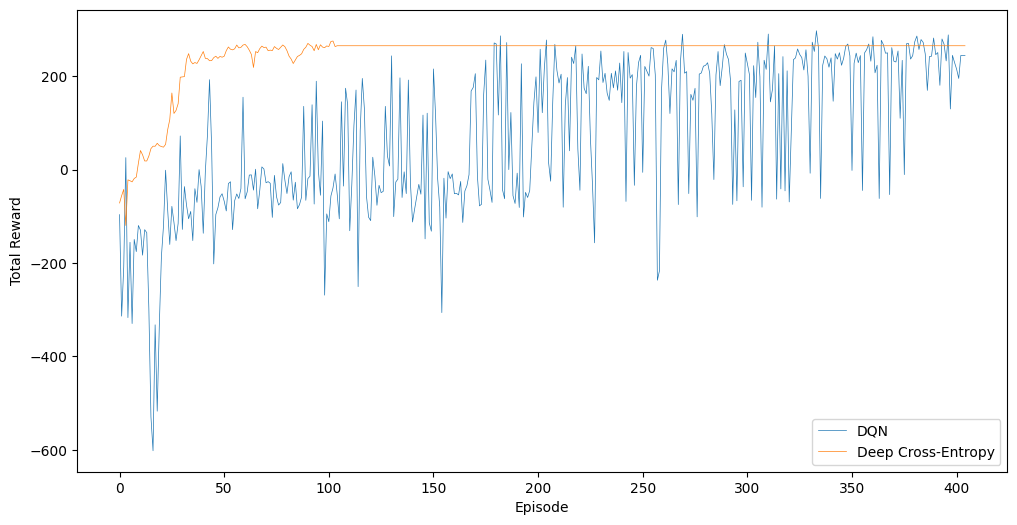

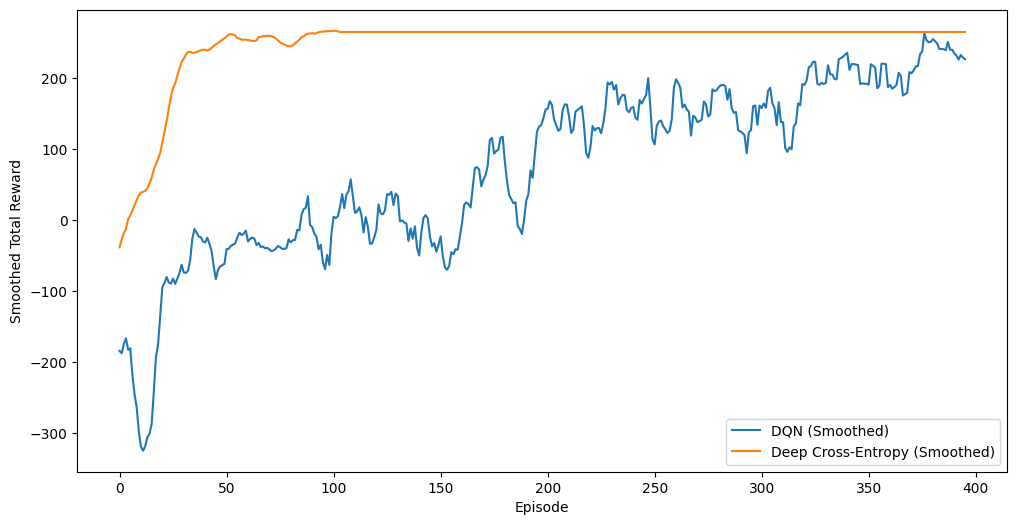

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(dqn_rewards[:405], label='DQN', linewidth=0.5)
plt.plot(deep_cross_entropy_rewards[:405], label='Deep Cross-Entropy', linewidth=0.5)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

window_size = 10

plt.figure(figsize=(12, 6))

smoothed_dqn_rewards = np.convolve(dqn_rewards[:405], np.ones(window_size)/window_size, mode='valid')
smoothed_deep_cross_entropy_rewards = np.convolve(deep_cross_entropy_rewards[:405], np.ones(window_size)/window_size, mode='valid')

plt.plot(smoothed_dqn_rewards, label='DQN (Smoothed)', linewidth=1.5)
plt.plot(smoothed_deep_cross_entropy_rewards, label='Deep Cross-Entropy (Smoothed)', linewidth=1.5)

plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.legend()
plt.show()

# Analysis and Conclusion

DCEM converged for around 102 * 200 = 20400 trajectories, while DQN required significantly less trajectories to converge (around 400). DQN appears to be more robust solution for the LunarLander-v2 environment.